# Non-uniform coefficients

From 5.6.2 of Polyanin - Handbook of nonlinear partial differential equations

$\frac{\partial w}{\partial t}=a \frac{\partial^2 w}{\partial x^2}+(b x+c) \frac{\partial w}{\partial x}+f(w)$.

This equation governs unsteady mass transfer with a volume chemical reaction in an inhomogeneous fluid flow.
$1^{\circ}$. Suppose $w(x, t)$ is a solution of the equation in question. Then the function
$$
w_1=w\left(x+C_1 e^{-b t}, t+C_2\right)
$$
where $C_1$ and $C_2$ are arbitrary constants, is also a solution of the equation.
$2^{\circ}$. Generalized traveling-wave solution:
$$
w=w(z), \quad z=x+C_1 e^{-b t},
$$
where the function $w(z)$ is determined by the ordinary differential equation
$$
a w_{z z}^{\prime \prime}+(b z+c) w_z^{\prime}+f(w)=0
$$

## Example 1
$\frac{\partial w}{\partial t}=a \frac{\partial^2 w}{\partial x^2}+ (b x + c) \frac{\partial w}{\partial x}$.


$f = 0$. Then the solution is then

$$
w(z) = c_2+c_1 \exp \bigg({\frac{c^2}{2 a b}} \bigg)\sqrt{\frac{a\pi}{2b}}  \operatorname{Erf}\left[\frac{c+b z}{\sqrt{2ab}}\right]
$$



In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps
from scipy.io import loadmat
from scipy.integrate import solve_ivp
from scipy.special import erf

In [92]:
t = np.linspace(-5, 5, 400)
x = np.linspace(-10, 10, 200)

C1 = 1
C2 = 1
a = 1
b = 1
c = 1
X, T = np.meshgrid(x, t, indexing="ij")
XT = np.stack([X, T],axis=2)
Z = X + C1*np.exp(-b * T)
W = C2+C1*np.exp(c**2/(2*a*b))*np.sqrt(a*np.pi/(2*b))*erf( (c + Z)/np.sqrt(2*a*b))

#W = C2 + 2*a/(np.sqrt(-2*a*b*C1-c**2))*np.arctan((c+b*(X+C1*np.exp(-b*T)))/np.sqrt(-2*a*b*C1-c**2))
print(f"{X.shape = }, {T.shape = }, {XT.shape = }, {W.shape = }")

X.shape = (200, 400), T.shape = (200, 400), XT.shape = (200, 400, 2), W.shape = (200, 400)


We make sure that all variables follow `x` then `t` axes

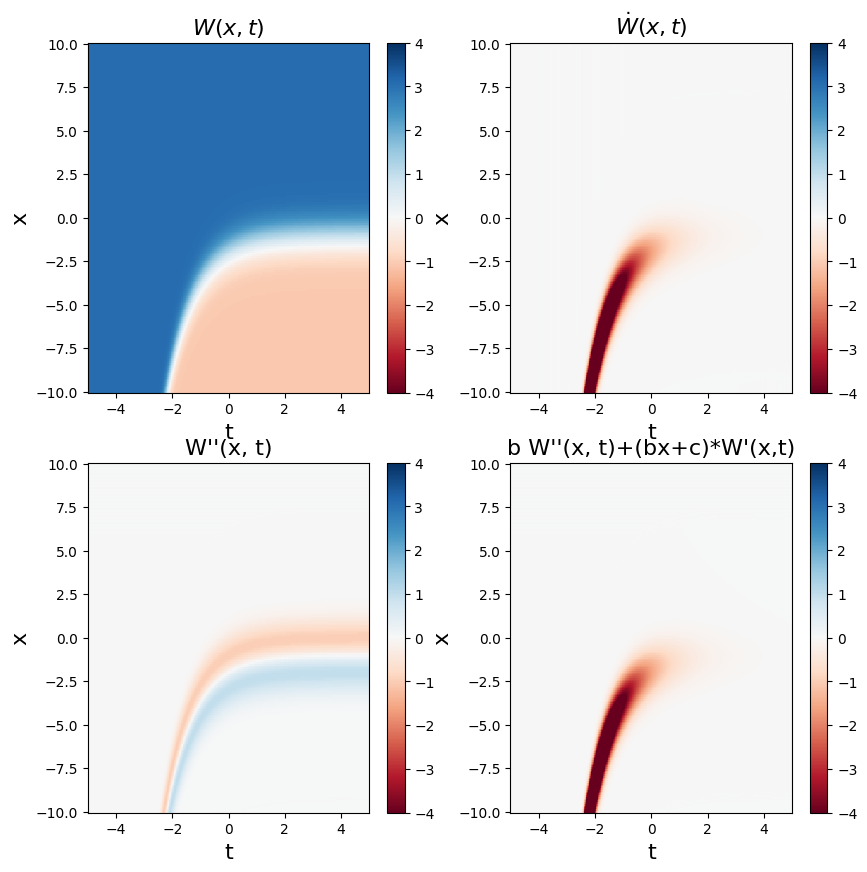

In [93]:
# Plot u and u_dot
W_dot = ps.FiniteDifference(axis=1)._differentiate(W, t=t)
dWdx = ps.FiniteDifference(axis=0)._differentiate(W, t=x)
d2Wdx2 = ps.FiniteDifference(axis=0,d=2)._differentiate(W, t=x)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.pcolormesh(T, X, W, vmin=-4, vmax=4,cmap="RdBu")
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$W(x, t)$", fontsize=16)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.pcolormesh(T, X, W_dot, vmin=-4, vmax=4,cmap="RdBu")
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$\dot W(x, t)$", fontsize=16)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.pcolormesh(T, X, d2Wdx2, vmin=-4, vmax=4,cmap="RdBu")
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title("W''(x, t)", fontsize=16)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.pcolormesh(T, X, a*d2Wdx2+(b*X+c)*dWdx, vmin=-4, vmax=4,cmap="RdBu")
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title("b W''(x, t)+(bx+c)*W'(x,t)", fontsize=16)
plt.colorbar()
plt.show()

Clearly, the solution works!

## Adding `x` dependence

Now we prepare the PDE library. 

In [99]:
sol = W[...,np.newaxis]
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=False,
)

We have a problem however: the library we created does not allow for dependence of coefficients on `x`. One way to add `x` to the library is to actually consider it as a source term `u`, another fitting parameter (control parameter). For more details on the corresponding SINDyCP examples see `pysindy/examples/17_parameterized_pattern_formation/parameterized_pattern_formation.ipynb`

In [128]:
%%time
# Run optimizers
for threshold in [0.05, 0.09,0.1, 0.15, 0.2, 0.021,0.03]: # parameter sweep for threshold of coefficient elimination
    print("==========================================")
    for alpha in [0.0001,0.001,0.01,0.05,0.1,0.5,1,10,100,1000]:   # parameter sweep for alpha of ridge regression
        optimizer = ps.STLSQ(threshold=threshold, alpha=alpha, normalize_columns=True)
        model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
        model.fit(sol, u =X[...,np.newaxis])
        print(f"threshold = {threshold:.3f}, alpha = {alpha:.3f}", end="\t")
        model.print()

threshold = 0.050, alpha = 0.000	(x0)' = 0.993 x0_1 + 1.002 x0_11 + 0.997 u0x0_1
threshold = 0.050, alpha = 0.001	(x0)' = 1.020 x0_1 + 0.989 x0_11 + 1.009 u0x0_1 + 0.004 u0u0x0_1 + 0.018 x0x0_11 + -9.004 x0u0_11
threshold = 0.050, alpha = 0.010	(x0)' = 1.000 x0_1 + 1.002 x0_11 + 1.005 u0x0_1 + 0.002 u0u0x0_1
threshold = 0.050, alpha = 0.050	(x0)' = 1.006 x0_1 + 1.009 x0_11 + 1.012 u0x0_1 + 0.004 u0u0x0_1 + 0.001 u0x0_11 + 0.313 x0x0u0_11
threshold = 0.050, alpha = 0.100	(x0)' = 6.590 u0x0_1 + 4.264 x0x0x0_1 + 2.355 u0u0x0_1 + 10.560 x0x0_11 + -6.950 u0x0_11 + -1.501 u0u0x0_11 + 59.889 x0x0u0_11
threshold = 0.050, alpha = 0.500	(x0)' = 2.277 x0x0_1 + 4.084 u0x0_1 + 0.393 x0x0x0_1 + 1.467 u0u0x0_1 + 4.647 x0x0_11 + -5.178 u0x0_11 + -1.191 u0u0x0_11 + 95.694 x0x0u0_11
threshold = 0.050, alpha = 1.000	(x0)' = 2.277 x0x0_1 + 4.084 u0x0_1 + 0.393 x0x0x0_1 + 1.467 u0u0x0_1 + 4.647 x0x0_11 + -5.178 u0x0_11 + -1.191 u0u0x0_11 + 95.694 x0x0u0_11
threshold = 0.050, alpha = 10.000	(x0)' = 0.000
th

It is possible to find a combination of `alpha` and `threshold` that provide nearly precise coefficients

## Expanding the function space

It will also work if we simply append `x` to the `sol`. 

In [138]:
sol = np.stack([W,X],axis=-1)
sol_dot = ps.FiniteDifference(axis=1)._differentiate(sol, t=t)
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=False,
)
sol.shape, sol_dot.shape

((200, 400, 2), (200, 400, 2))

In [139]:
%%time
# Run optimizers
for threshold in [0.05, 0.09,0.1, 0.15, 0.2, 0.021,0.03]: # parameter sweep for threshold of coefficient elimination
    print("==========================================")
    for alpha in [0.0001,0.001,0.01,0.05,0.1,0.5,1,10,100,1000]:   # parameter sweep for alpha of ridge regression
        optimizer = ps.STLSQ(threshold=threshold, alpha=alpha, normalize_columns=True)
        model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
        model.fit(sol)
        print(f"threshold = {threshold:.3f}, alpha = {alpha:.3f}", end="\t")
        model.print()

threshold = 0.050, alpha = 0.000	(x0)' = 0.999 x0_1 + 1.002 x0_11 + 1.001 x1x0_1
(x1)' = 0.000
threshold = 0.050, alpha = 0.001	(x0)' = 1966362503.332 x0 + 578049535.596 x0x0 + -2.646 x0_1 + 3.978 x1_1 + 1.795 x0_11 + 0.491 x0x0_1 + 1.001 x1x0_1 + -0.066 x0x0x0_1 + -1966362500.899 x0x1_1 + -578049536.812 x0x0x1_1 + -0.452 x0x0_11 + 0.020 x0x0x0_11 + 62.445 x0x1_11 + -10.219 x0x0x1_11
(x1)' = 0.000
threshold = 0.050, alpha = 0.010	(x0)' = 0.835 x0_1 + 1.187 x0_11 + 0.170 x0x0_1 + 1.001 x1x0_1 + -0.017 x0x0_11 + 0.003 x1x0_11 + 0.009 x0x0x0_11 + 6.087 x0x1_11 + -4.721 x0x0x1_11
(x1)' = 0.000
threshold = 0.050, alpha = 0.050	(x0)' = 1.008 x0_1 + 0.997 x0_11 + 1.001 x1x0_1 + 0.001 x1x0_11 + 0.002 x0x0x0_11 + -4.786 x0x1_11
(x1)' = 0.000
threshold = 0.050, alpha = 0.100	(x0)' = 1.008 x0_1 + 0.997 x0_11 + 1.001 x1x0_1 + 0.001 x1x0_11 + 0.002 x0x0x0_11 + -4.786 x0x1_11
(x1)' = 0.000
threshold = 0.050, alpha = 0.500	(x0)' = 9223875691.587 x0 + -18545457309.333 x1 + 1054222958.799 x1x1 + 0.982 

The issue may arise however if we are fitting some more complex function whose derivative is not zero that could potentially fit some wrong expressions. In order to avoid this we could potentially overwrite the `x_dot` kwarg like it is done in the end of `pysindy/examples/1_feature_overview/example.ipynb`